In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nptdms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nptdms: filename=nptdms-1.10.0-py3-none-any.whl size=108456 sha256=b189d6212b8b9a1653d38058b45cf5fa8d857180442186f3940253133492ccb5
  Stored in directory: /root/.cache/pip/wheels/1b/4b/17/21e8b03b37ea51ce7ec9f5570cdf0decca93f537d61c06880f
Successfully built nptdms


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, concatenate, LSTM, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
from scipy.fft import rfft
import pywt
from nptdms import TdmsFile
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
import joblib

import pandas as pd
from sklearn.linear_model import LinearRegression

from tensorflow.keras import regularizers

데이터 불러오기

In [4]:
def load_tdms_file(file_path):
    tdms_file = TdmsFile.read(file_path)

    group_name_vibration = tdms_file.groups()[0].name
    group_name_operation = tdms_file.groups()[1].name

    vib_channels = tdms_file[group_name_vibration].channels()
    vib_data = {ch.name.strip(): ch.data for ch in vib_channels}

    operation_channels = tdms_file[group_name_operation].channels()
    operation_data = {ch.name.strip(): ch.data for ch in operation_channels}

    return vib_data, operation_data

### operation slope

In [6]:
# TDMS 파일에서 operation data 불러오기
def get_train_folders(train_root):
    all_folders = os.listdir(train_root)
    train_folders = [f for f in all_folders if f.lower().startswith("train") and os.path.isdir(os.path.join(train_root, f))]
    return sorted(train_folders)
def load_summary_from_tdms(train_root, target_folders):
    summary = {}

    for folder in target_folders:
        folder_path = os.path.join(train_root, folder)
        tdms_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tdms")])

        records = []

        for idx, tdms_file in enumerate(tdms_files):
            file_path = os.path.join(folder_path, tdms_file)
            _, operation_data = load_tdms_file(file_path)

            time_sec = idx * 600  # 10분 간격

            record = {
                "time_sec": time_sec,
                "TC SP Front[℃]": operation_data["TC SP Front[℃]"][0],
                "TC SP Rear[℃]": operation_data["TC SP Rear[℃]"][0],
                "Torque[Nm]": operation_data["Torque[Nm]"][0],
                "file_name": os.path.splitext(tdms_file)[0],  # 확장자 제거
                "folder": folder
            }
            records.append(record)

        df = pd.DataFrame(records)
        summary[folder] = df

    return summary

# slope 계산
def compute_slope_feature(df, column_name, N, interval_sec=600):
    """
    주어진 데이터프레임에서 column_name에 대한 slope 피처 계산
    """
    slope_col = f"{column_name}_Slope_{N}cycle"
    slopes = [np.nan] * len(df)
    for i in range(N, len(df)):
        delta_y = df[column_name].iloc[i] - df[column_name].iloc[i - N]
        delta_x = df["time_sec"].iloc[i] - df["time_sec"].iloc[i - N]
        slopes[i] = delta_y / delta_x
    df[slope_col] = slopes
    return df

# TC_slope x Torque_slope
def compute_combined_slope(df, temp_col, torque_col, N):
    """
    온도 slope와 토크 slope의 곱 (복합 지표)
    """
    temp_slope_col = f"{temp_col}_Slope_{N}cycle"
    torque_slope_col = f"{torque_col}_Slope_{N}cycle"
    combined_col = f"Combined_Slope_{N}cycle"
    if temp_slope_col in df.columns and torque_slope_col in df.columns:
        df[combined_col] = df[temp_slope_col] * df[torque_slope_col]
    return df

def apply_slope_features(summary, estimation_targets, N_list=[3, 5], interval_sec=600):
    """
    모든 summary 데이터프레임에 대해 slope 및 combined slope 피처 추가
    """
    for train_id, df in summary.items():
        front_col, rear_col = estimation_targets.get(train_id, ("TC SP Front[℃]", "TC SP Rear[℃]"))
        df = df.copy()
        for N in N_list:
            df = compute_slope_feature(df, "Torque[Nm]", N, interval_sec)
            df = compute_slope_feature(df, front_col, N, interval_sec)
            df = compute_slope_feature(df, rear_col, N, interval_sec)
            df = compute_combined_slope(df, front_col, "Torque[Nm]", N)
            df = compute_combined_slope(df, rear_col, "Torque[Nm]", N)
        summary[train_id] = df
    return summary



수행

In [7]:
train_root = "/content/drive/MyDrive/KSPHM-data-challenge/Train Set"

# 1. Train 폴더 및 대상 변수 설정
train_folders = get_train_folders(train_root)
targets = {folder: ("TC SP Front[℃]", "TC SP Rear[℃]") for folder in train_folders}

# 2. TDMS 요약 로딩
summary = load_summary_from_tdms(train_root, train_folders)

# 5. slope 피처 생성
summary = apply_slope_features(summary, targets)

#### 확인

In [11]:
train_id = "Train6"  # 실제 폴더 이름으로 바꿔야 함
df = summary[train_id]

# 마지막 3개의 시점과 값
y3 = df["TC SP Front[℃]"].iloc[-1]
y0 = df["TC SP Front[℃]"].iloc[-4]
x3 = df["time_sec"].iloc[-1]
x0 = df["time_sec"].iloc[-4]

manual_slope = (y3 - y0) / (x3 - x0)
print("Manual slope:", manual_slope)
print("Computed slope:", df["TC SP Front[℃]_Slope_3cycle"].iloc[-1])
# 값이 일치하면 정상

Manual slope: 0.002769833333333338
Computed slope: 0.002769833333333338


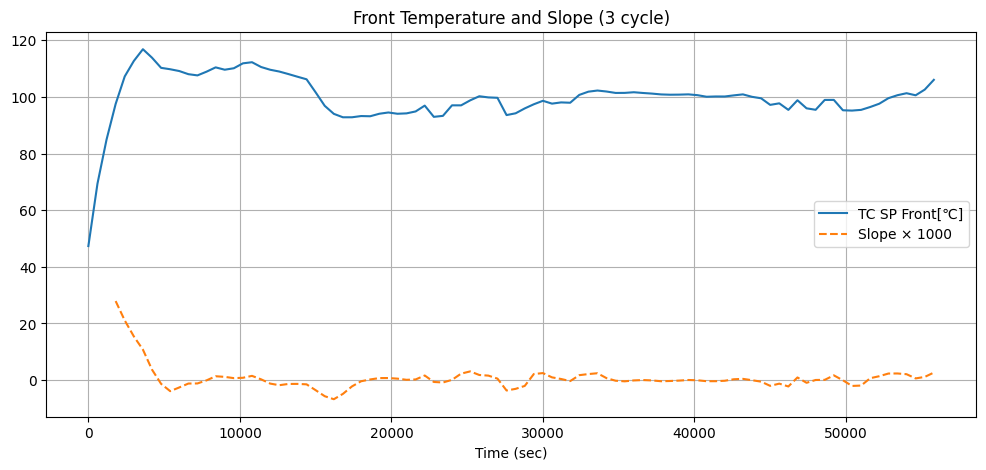

In [12]:
import matplotlib.pyplot as plt

df = summary["Train1"]

plt.figure(figsize=(12, 5))
plt.plot(df["time_sec"], df["TC SP Front[℃]"], label="TC SP Front[℃]")
plt.plot(df["time_sec"], df["TC SP Front[℃]_Slope_3cycle"] * 1000, label="Slope × 1000", linestyle="--")
plt.xlabel("Time (sec)")
plt.legend()
plt.grid()
plt.title("Front Temperature and Slope (3 cycle)")
plt.show()
# 시각화

In [13]:
print(df[["TC SP Front[℃]_Slope_3cycle"]].isna().sum())
# 처음 N개는 없어야 함

TC SP Front[℃]_Slope_3cycle    3
dtype: int64


In [15]:
df

,time_sec,TC SP Front[℃],TC SP Rear[℃],Torque[Nm],file_name,folder,Torque[Nm]_Slope_3cycle,TC SP Front[℃]_Slope_3cycle,TC SP Rear[℃]_Slope_3cycle,Combined_Slope_3cycle,Torque[Nm]_Slope_5cycle,TC SP Front[℃]_Slope_5cycle,TC SP Rear[℃]_Slope_5cycle,Combined_Slope_5cycle
0,0,47.3274,56.6218,-10.352493,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,600,69.3558,83.0182,-9.625572,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1200,84.9585,106.7807,-10.501605,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1800,97.5308,123.6613,-9.528453,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,0.000458,0.027891,0.037244,1.705038e-05,NaN,NaN,NaN,NaN
4,2400,107.2604,142.7980,-11.160837,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,-0.000853,0.021058,0.033211,-2.832649e-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,53400,100.6211,153.8347,-7.372215,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,0.001032,0.002317,0.003909,4.035216e-06,0.000218,0.001811,0.005006,1.091919e-06
90,54000,101.3231,156.6417,-6.857190,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,0.000265,0.002058,-0.002547,-6.746680e-07,0.000291,0.001961,0.003816,1.109381e-06
91,54600,100.5940,181.6120,-8.219799,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,0.002530,0.000572,0.005778,1.461855e-05,0.000337,0.001381,0.011605,3.908557e-06
92,55200,102.5969,175.5891,-7.352595,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1,0.000011,0.001098,0.012086,1.317350e-07,-0.000006,0.001660,0.004788,-2.974474e-08


### vibration 고장 주파수

In [17]:
# 고장 주파수 정의 (단위: Hz)
FAULT_FREQUENCIES = {
    "BPFI": 140,
    "BPFO": 93,
    "BSF": 78,
    "Cage": 6.7
}

# 단일 채널 고장 주파수 특징 추출(FFT)
def extract_fault_frequency_features(signal, Fs, fault_freqs=FAULT_FREQUENCIES, bandwidth=5):
    """
    단일 진동 신호에서 FFT 기반 고장 주파수 특징 추출
    """
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/Fs)[:N//2]
    fft_magnitude = np.abs(np.fft.fft(signal))[:N//2]

    features = {}

    for fault_name, f_center in fault_freqs.items():
        lower = f_center - bandwidth
        upper = f_center + bandwidth
        band_mask = (freqs >= lower) & (freqs <= upper)
        band_energy = np.sum(fft_magnitude[band_mask] ** 2)

        # 대역 내 최대 진폭 및 해당 주파수
        if np.any(band_mask):
            peak_idx = np.argmax(fft_magnitude[band_mask])
            band_freqs = freqs[band_mask]
            band_mags = fft_magnitude[band_mask]
            peak_amp = band_mags[peak_idx]
            peak_freq = band_freqs[peak_idx]
        else:
            peak_amp = 0.0
            peak_freq = 0.0

        features[f"{fault_name}_Energy"] = band_energy
        features[f"{fault_name}_Peak_Amplitude"] = peak_amp
        features[f"{fault_name}_Peak_Frequency"] = peak_freq

    return features

# 멀티 채널 고장 주파수 특징 추출
def extract_fault_features_from_tdms(vib_data, duration_sec=10, bandwidth=5):
    """
    TDMS 진동 데이터(CH1~CH4)에서 고장 주파수 특징 추출
    - vib_data: TDMS에서 읽은 dict ({"CH1": array, ...})
    - duration_sec: 시퀀스 길이 (기본 10초)
    """
    features = {}
    channels = ["CH1", "CH2", "CH3", "CH4"]

    # 샘플 수 → Fs 계산
    sample_counts = [len(vib_data[ch]) for ch in channels if ch in vib_data]
    if not sample_counts:
        raise ValueError("No valid vibration channels found.")
    N = sample_counts[0]
    Fs = N / duration_sec  # 샘플링 주파수

    for ch in channels:
        if ch not in vib_data:
            continue
        signal = vib_data[ch]
        fault_feats = extract_fault_frequency_features(signal, Fs, bandwidth=bandwidth)
        for k, v in fault_feats.items():
            features[f"{ch}_{k}"] = v

    return features

# 파일 한 개 적용
def extract_fault_features_from_file(file_path, duration_sec=10, bandwidth=5):
    """
    단일 TDMS 파일에서 FFT 기반 고장 주파수 특징 추출
    """
    vib_data, _ = load_tdms_file(file_path)
    features = extract_fault_features_from_tdms(vib_data, duration_sec=duration_sec, bandwidth=bandwidth)
    features["file_path"] = file_path
    features["file_name"] = os.path.splitext(os.path.basename(file_path))[0]
    return features

# 모든 tdms 파일 적용
def extract_fault_features_all(train_root, target_folders=None, bandwidth=5):
    """
    Train Set 전체 TDMS 파일에 대해 고장 주파수 기반 FFT 피처 추출
    """
    if target_folders is None:
        target_folders = sorted(os.listdir(train_root))

    all_records = []

    for folder in tqdm(target_folders, desc="Extracting fault features"):
        folder_path = os.path.join(train_root, folder)
        tdms_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tdms")])

        for tdms_file in tdms_files:
            file_path = os.path.join(folder_path, tdms_file)
            try:
                features = extract_fault_features_from_file(file_path, bandwidth=bandwidth)
                features["folder"] = folder
                all_records.append(features)
            except Exception as e:
                print(f"Failed to process {file_path}: {e}")

    df = pd.DataFrame(all_records)
    return df

In [18]:
train_root = "/content/drive/MyDrive/KSPHM-data-challenge/Train Set"
fault_features_df = extract_fault_features_all(train_root)

# 결과 확인 (상위 5개 출력)
fault_features_df.head()

Extracting fault features: 100%|██████████| 8/8 [02:48<00:00, 21.12s/it]


,CH1_BPFI_Energy,CH1_BPFI_Peak_Amplitude,CH1_BPFI_Peak_Frequency,CH1_BPFO_Energy,CH1_BPFO_Peak_Amplitude,CH1_BPFO_Peak_Frequency,CH1_BSF_Energy,CH1_BSF_Peak_Amplitude,CH1_BSF_Peak_Frequency,CH1_Cage_Energy,...,CH4_BPFO_Peak_Frequency,CH4_BSF_Energy,CH4_BSF_Peak_Amplitude,CH4_BSF_Peak_Frequency,CH4_Cage_Energy,CH4_Cage_Peak_Amplitude,CH4_Cage_Peak_Frequency,file_path,file_name,folder
0,26534.458984,106.403908,139.5,245777.953125,392.719330,92.9,160446.156250,206.272400,78.0,248901.765625,...,92.9,590267.12500,574.414368,78.0,91901.351562,93.047493,11.5,/content/drive/MyDrive/KSPHM-data-challenge/Tr...,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1
1,34936.980469,134.184967,139.5,69369.531250,148.070572,92.9,111298.929688,183.534882,78.0,14120.650391,...,92.9,409202.09375,448.622192,78.0,85546.023438,111.662666,11.4,/content/drive/MyDrive/KSPHM-data-challenge/Tr...,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1
2,16490.882812,64.369659,139.4,299889.468750,483.930115,92.8,151511.562500,251.580444,82.9,29525.212891,...,92.8,503078.43750,442.747223,77.9,38633.257812,67.343948,2.0,/content/drive/MyDrive/KSPHM-data-challenge/Tr...,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1
3,16321.380859,59.074722,139.4,404591.375000,472.327972,92.9,227975.843750,346.696411,82.9,88167.914062,...,92.9,414805.84375,405.883423,82.9,65910.585938,66.462685,11.5,/content/drive/MyDrive/KSPHM-data-challenge/Tr...,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1
4,14489.788086,68.631294,143.0,372469.750000,539.431641,93.0,83994.937500,156.128387,78.1,95633.453125,...,93.0,256717.34375,399.323029,78.1,59362.769531,57.131557,10.9,/content/drive/MyDrive/KSPHM-data-challenge/Tr...,modified_KIMM Simulator_KIMM Bearing Test_2016...,Train1


### slope + 고장 주파수